In [1]:
import tensorflow as tf
import numpy
import scipy.io
#from tensorflow.python.client import timeline
import time

percorsoDati = "/home/protoss/hanford.mat"

struttura = scipy.io.loadmat(percorsoDati)['hanford']

peakmap = struttura[9002].copy()

del struttura
peakmap = peakmap[:,25:80]
from matplotlib import pyplot
%matplotlib notebook
pyplot.figure(figsize=(10, 8))
#a = pyplot.scatter(numpy.arange(tempiUnici.size),tempiUnici/30, s = 0.5)
a = pyplot.imshow(peakmap, origin = 'lower', interpolation = 'none')

FileNotFoundError: [Errno 2] No such file or directory: '/home/protoss/hanford.mat'

<IPython.core.display.Javascript object>


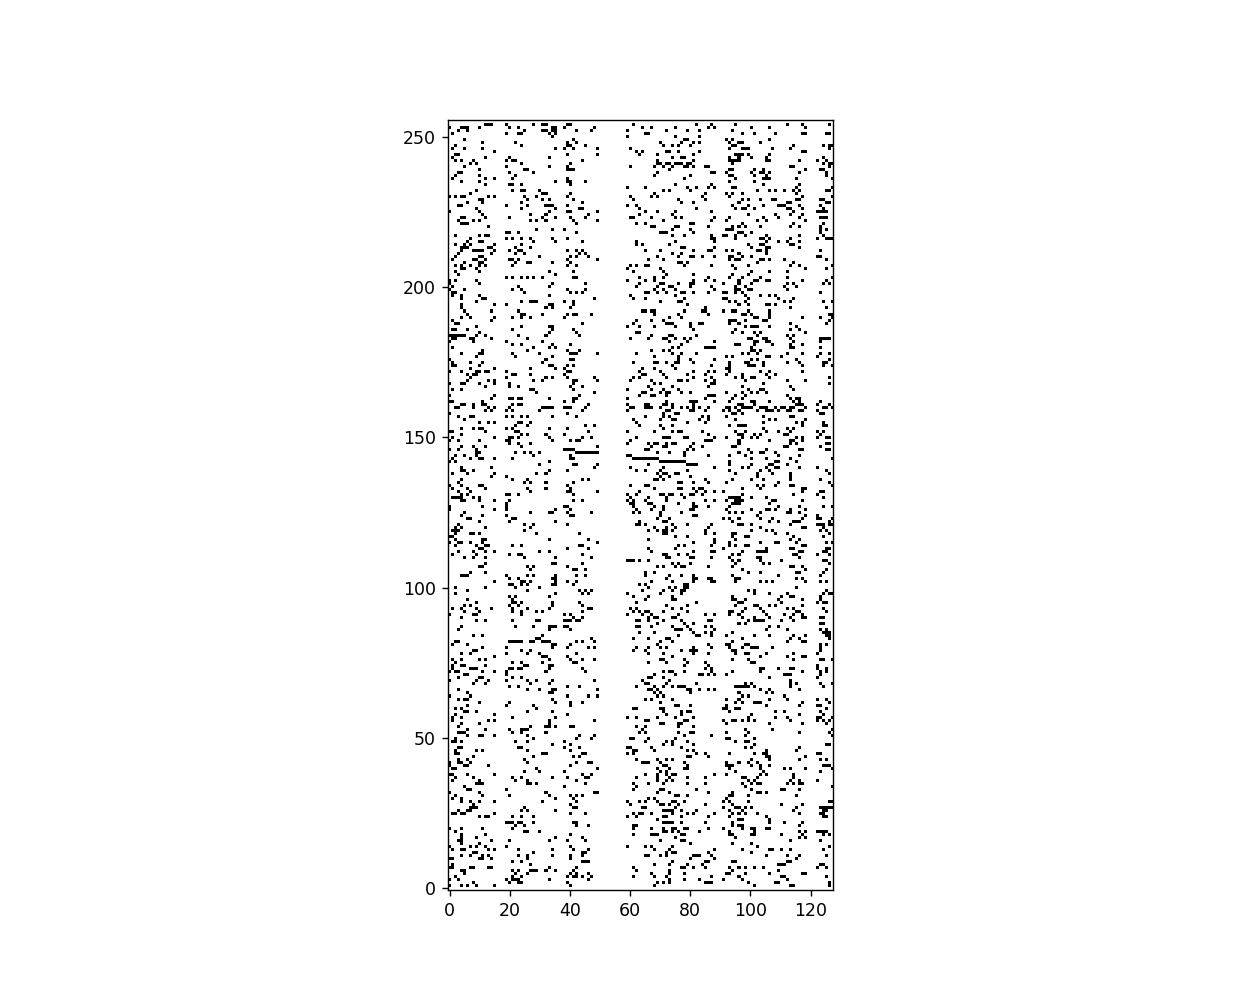

In [5]:
import tensorflow as tf
import numpy
import scipy.io
#from tensorflow.python.client import timeline
import time

percorsoDati = "/home/protoss/wn100bkp/dati/datiFederico4.mat"
#index = 9002 #signal
index = 4 #signal meno bello
#index = 5001
#index = 0

struttura1 = scipy.io.loadmat(percorsoDati)['H']
peakmap1 = struttura1[index].copy()
del struttura1

struttura2 = scipy.io.loadmat(percorsoDati)['L']
peakmap2 = struttura2[index].copy()
del struttura2

struttura3 = scipy.io.loadmat(percorsoDati)['V']
peakmap3 = struttura3[index].copy()
del struttura3

peakmapTOT = peakmap1+peakmap2+peakmap3

peakmap = peakmapTOT

filtro = numpy.nonzero(peakmap)
peakmap[filtro] = 1




#scipy.io.savemat


#peakmap = peakmapTOT[:,25:80]

from matplotlib import pyplot
%matplotlib qt
pyplot.figure(figsize=(10, 8))
#a = pyplot.scatter(numpy.arange(tempiUnici.size),tempiUnici/30, s = 0.5)
a = pyplot.imshow(peakmap, cmap = 'binary', origin = 'lower', interpolation = 'none')






In [4]:
#tFft = 4096
tFft = 8192
tObs = 1/5 #mesi
tObs = tObs*30*24*60*60
nPunti = 2
cands = 100
primaFreq = 1/tFft
securbelt = 2000

sparsa = numpy.nonzero(peakmap)

frequenze,tempi = sparsa
tempi = tempi+1
frequenze = frequenze / tFft + 1
pesi = numpy.ones(sparsa[0].size)

scipy.io.savemat("/home/protoss/wn100bkp/dati/peakmap0fed.mat",{"freq":frequenze, "tempi": tempi})


In [3]:
#peakmap = struttura[0]

tFft = 8192
#tFft = 4096
tObs = 1/5 #mesi
tObs = tObs*30*24*60*60

sparsa = numpy.nonzero(peakmap)

frequenze,tempi = sparsa
tempi = tempi+1
frequenze = frequenze / tFft + 1
pesi = numpy.ones(sparsa[0].size)



#headers vari
securbelt = 200000


#frequenze
#frequenze
stepFrequenza = 1/tFft
enhancement = 10
stepFreqRaffinato =  stepFrequenza/enhancement

freqMin = numpy.amin(frequenze)
freqMax = numpy.amax(frequenze)
freqIniz = freqMin- stepFrequenza/2 - stepFreqRaffinato
freqFin = freqMax + stepFrequenza/2 + stepFreqRaffinato
nstepFrequenze = numpy.ceil((freqFin-freqIniz)/stepFreqRaffinato)+securbelt

#tempi
#epoca definita come mediana di tempi di tutto il run
#epoca = (57722+57990)/2 #0
epoca =70

#spindowns
spindownMin = -3*1e-8#-16-2*1e-9
spindownMax = +3*1e-8

stepSpindown = stepFrequenza/tObs
nstepSpindown = numpy.round((spindownMax-spindownMin)/stepSpindown).astype(numpy.int32)

#nstepSpindown = 10*2*2*(20)#numpy.round((spindownMax-spindownMin)/stepSpindown).astype(numpy.int32)
print(nstepSpindown)

#stepSpindown = (spindownMax-spindownMin)/nstepSpindown#stepFrequenza/tObs 
print(stepSpindown)


# riarrangio gli array in modo che abbia i dati 
# nel formato che voglio io
frequenze = frequenze-freqIniz
frequenze = (frequenze/stepFreqRaffinato)-round(enhancement/2+0.001)

tempi = tempi-epoca
tempi = ((tempi)*3600*24/stepFreqRaffinato)
#tempi = numpy.round(tempi/1e8)*1e8

spindowns = numpy.arange(0, nstepSpindown)
spindowns = numpy.multiply(spindowns,stepSpindown)
spindowns = numpy.add(spindowns, spindownMin)
# così ho i tre array delle tre grandezze, 
#più i pesi e la fascia di sicurezza
#indice0 = numpy.where(spindowns>0)[0][0]-1
#print(indice0)
#spindowns = spindowns-spindowns[indice0]


319
1.8838011188271604e-10


In [4]:


def mapnonVar(stepIesimo):
    sdTimed = tf.multiply(spindownsTF[stepIesimo], tempiTF, name = "Tdotpert")
    #sdTimed = tf.cast(sdTimed, dtype=tf.float32)
    
    appoggio = tf.round(frequenzeTF-sdTimed+securbeltTF/2, name = "appoggioperindici")
    appoggio = tf.cast(appoggio, dtype=tf.int64)
    
    valori = tf.unsorted_segment_sum(pesiTF, appoggio, nColumns)

#    zeriDopo = tf.zeros([nColumns - tf.size(valori)], dtype=tf.float32)    
#    riga = tf.concat([valori,zeriDopo],0, name = "rigadihough")
    return valori


#ora uso Tensorflow
securbeltTF = tf.constant(securbelt,dtype=tf.float64)
tempiTF = tf.constant(tempi,dtype=tf.float64)
pesiTF = tf.constant(pesi,dtype=tf.float64)
spindownsTF = tf.constant(spindowns, dtype=tf.float64)
frequenzeTF = tf.constant(frequenze, dtype=tf.float64)

nRowsTF = tf.constant(nstepSpindown, dtype=tf.int64)
nColumns = nstepFrequenze

pesiTF = tf.reshape(pesiTF,(1,tf.size(pesi)))
pesiTF = pesiTF[0]

imagenonVar = tf.map_fn(mapnonVar, tf.range(0, nRowsTF), dtype=tf.float64, parallel_iterations=4)

#sessione = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sessione = tf.Session()

#run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
#run_metadata = tf.RunMetadata()

start = time.time()
#image = sessione.run(imagenonVar, options=run_options, run_metadata=run_metadata)
image = sessione.run(imagenonVar)
stop = time.time()
print(stop-start)


    # Create the Timeline object, and write it to a json
#tl = timeline.Timeline(run_metadata.step_stats)
#ctf = tl.generate_chrome_trace_format()
#with open('timelinenonVar.json', 'w') as f:
#	f.write(ctf)

nColumns = nColumns.astype(int)
semiLarghezza = numpy.round(enhancement/2+0.001).astype(int)
image[:,semiLarghezza*2:nColumns]=image[:,semiLarghezza*2:nColumns]-image[:,0:nColumns - semiLarghezza*2]
image = numpy.cumsum(image, axis = 1)
print(image.shape)

0.374009370803833
(319, 202543)


<IPython.core.display.Javascript object>


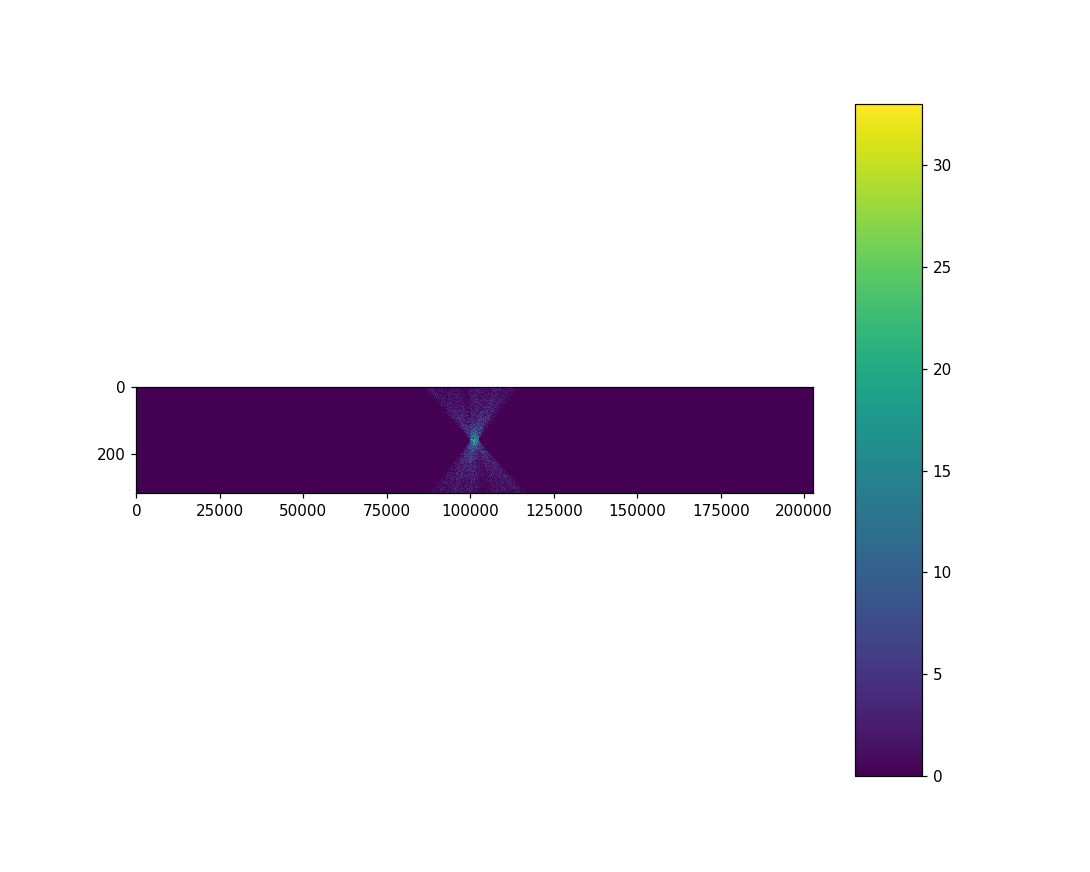

In [5]:
from matplotlib import pyplot
%matplotlib notebook
pyplot.figure(figsize=(10, 8))
a = pyplot.imshow(image, aspect = 100, interpolation = 'none')
#a = pyplot.imshow(image[94:98], aspect = 10000)
pyplot.colorbar(shrink = 1,aspect = 10)
#a = pyplot.imshow(image[191:192], aspect = 10000)
pyplot.show()
#DA METTER IN LOG

# CANDSEL

In [71]:
def manchurian_candidates(numCand, freqIniz, image):
    minDistance = enhancement*4

    candidati = numpy.zeros((9,numCand*2))

    primaFreq = freqIniz-(securbelt/2)*stepFreqRaffinato

    freqIniziale = 0
    freqFinale = (peakmap.shape[0]-1)*stepFrequenza
    
    #QUI ANALOGO FUNZIONE CUT GD2
    #%time indexInizialewh = numpy.where(freqniu>freqIniziale)[0][0]
    #%time indexFinalewh = numpy.where(freqniu>freqFinale)[0][0]
    start = time.time()

    indexIniziale = ((freqIniziale-primaFreq)/stepFreqRaffinato).astype(numpy.int64)
    indexFinale = ((freqFinale-primaFreq)/stepFreqRaffinato+1).astype(numpy.int64)

    imageCand = image[:,indexIniziale:indexFinale]
    
    size = numpy.shape(imageCand)[1]
    freqniu = numpy.arange(0,size)*stepFreqRaffinato+freqIniziale

    maxPerColumn = numpy.amax(imageCand, axis = 0)
    rigaMax = numpy.argmax(imageCand, axis = 0)
    #######################

    stepFrequenzaNiu = maxPerColumn.size/numCand

    indiciFreq = numpy.arange(0,maxPerColumn.size,stepFrequenzaNiu)
    indiciFreq = numpy.append(indiciFreq, maxPerColumn.size)
    indiciFreq = numpy.round(indiciFreq).astype(numpy.int64)

    def statistics(ndArray):
        #ndArray = numpy.ravel(ndArray)
        mediana = numpy.median(ndArray)
        sigmana = numpy.median(numpy.absolute(ndArray-mediana))/0.6745
        return mediana, sigmana

    stats = statistics(imageCand)
    medianaTot = stats[0]

    iniziali = numpy.concatenate(([indiciFreq[0]],indiciFreq[0:numCand-2],[indiciFreq[indiciFreq.size-3]]),0)
    finali = numpy.concatenate(([indiciFreq[2]-1],indiciFreq[3:numCand+1]-1,[indiciFreq[indiciFreq.size-1]-1]),0)

    def statsPerCand(i):
        stat = statistics(maxPerColumn[iniziali[i]:finali[i]])#[0]
        return stat

    statPerCand = numpy.array(list(map(statsPerCand, numpy.arange(numCand))))
    medianaPerCand = statPerCand[:,0]
    sigmanaPerCand = statPerCand[:,1]
    
    filtro = numpy.where(medianaPerCand > 0)[0]
    #medCandFiltrata = medianaPerCand[filtro]
    counter = 0
    for i in filtro:
        inizio = indiciFreq[i]
        fine = indiciFreq[i+1]-1
        porzioneMaxPerColumn = maxPerColumn[inizio:fine]
        localMax = numpy.amax(porzioneMaxPerColumn)
        localInd = numpy.argmax(porzioneMaxPerColumn)
        if localMax > medianaPerCand[i] and localMax > medianaTot/2:
            counter = counter + 1
            index = indiciFreq[i] + localInd-1
            candidati[0,counter] = freqniu[index]
            riga = rigaMax[index]
            candidati[3,counter] = spindowns[riga]
            candidati[4,counter] = localMax
            candidati[5,counter] = (localMax-medianaPerCand[i])/sigmanaPerCand[i]
            candidati[8,counter] = 1
    candidati[3,:]=numpy.round(candidati[3,:] / stepSpindown) * stepSpindown
    return candidati



candidati = manchurian_candidates(256, freqIniz, image)
nonzeri = numpy.nonzero(candidati[0])
finalCand = candidati[:,nonzeri]

[ 0.  0.  0. ...,  0.  0.  0.]
[0 0 0 ..., 0 0 0]


<IPython.core.display.Javascript object>


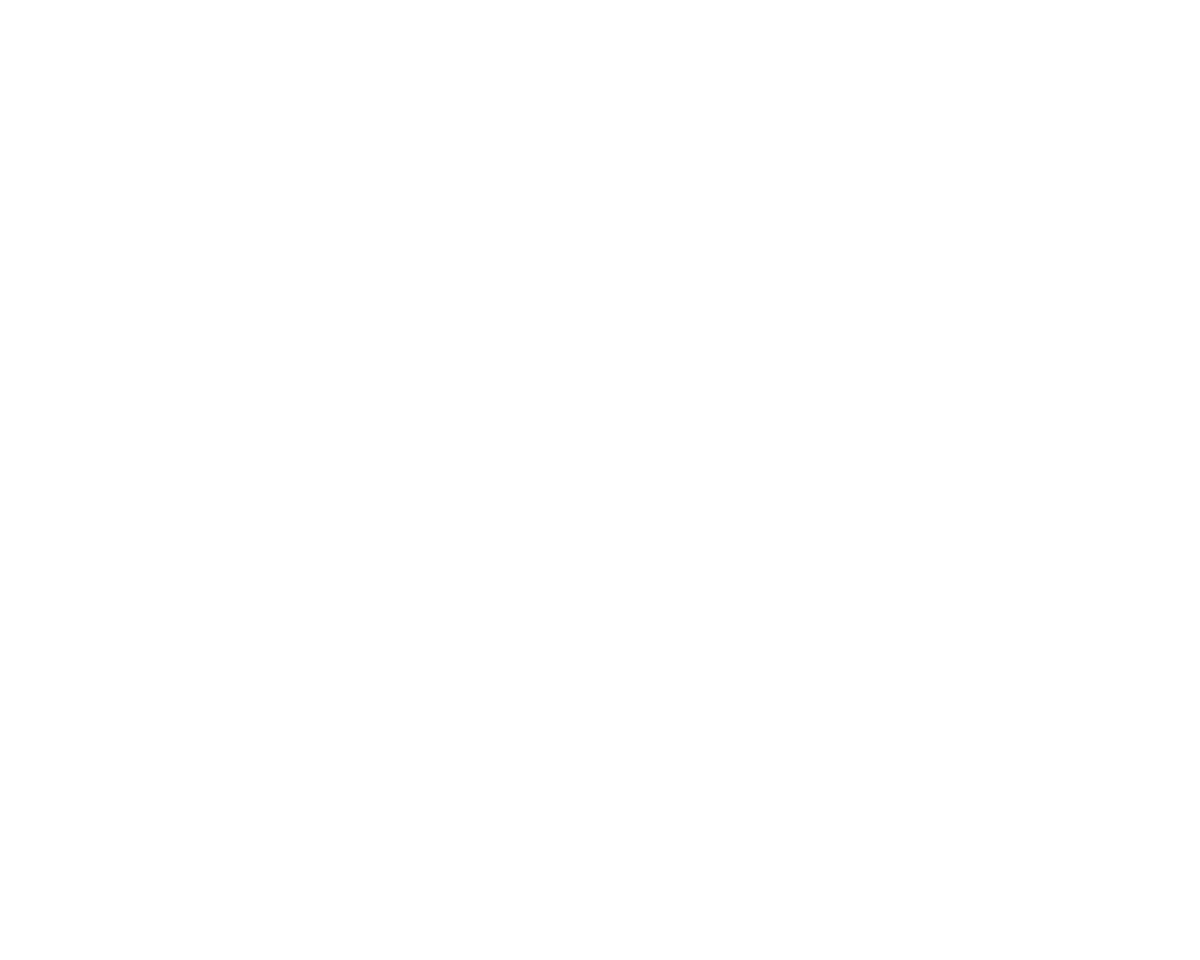

NameError: name 'imageCand' is not defined

In [72]:
from matplotlib import pyplot
%matplotlib notebook
pyplot.figure(figsize=(10, 8))
a = pyplot.imshow(imageCand, aspect = 1000, interpolation = 'none')
#a = pyplot.imshow(image[94:98], aspect = 10000)
pyplot.colorbar(shrink = 1,aspect = 10)
#a = pyplot.imshow(image[191:192], aspect = 10000)
pyplot.show()